In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, time, date, timedelta
import sys 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [2]:
#opening csv file provided by company - may need to clean up
dfraw = pd.read_csv("phonesystem_mod.csv", usecols=np.arange(14))
#dfraw = dfraw.reset_index()
#store number of rows and cols
row, col = dfraw.shape
print ("row num: " + str(row) + " || col num: " + str(col))

row num: 1542 || col num: 14


In [3]:
#after looking at the data we want to clean it up
#lets drop un-needed cols.
del dfraw['Unique ID']
del dfraw['Caller Extension']
del dfraw['Caller Comments']
del dfraw['Called Comments']
del dfraw['Answering Extension']
del dfraw['Information']
del dfraw['Reporting Group']
del dfraw['Report Flag']

In [4]:
# The dates and times given in the data needs to be of type "datetime"
#We extract the date and time now. 
#Construct datetime object (YYYY,MM,DD,hour,min,sec) by extracting it by slice

#create new column with same number of index:
#empty col ready to transfer formatted datetime values
dfraw["datetime"] = '' 

# store the rows of data into this temporary pandas series
dt_col = dfraw["Date/Time"] 


i = 0


for dt_ele in dt_col:
    
    # "dt_ele" contains a string: dd/mm/yyyy hh:mm:ss <-- lets extract this
    #by looping through each point of our date/time col and extracting
    #individual data by slicing:
    year = dt_ele[6:10]
    month = dt_ele[3:5]
    day = dt_ele[0:2]
    hour = dt_ele[11:13]
    mini = dt_ele[14:16]
    sec = dt_ele[17:21]
    
    #create a datetime object for that element
    formatted_dt = datetime(int(year),int(month),int(day),int(hour),int(mini),int(sec))

    #plug this formatted datetime value into our new col called datetime by appending.
    #as we are looping from the begining of the col
    dfraw.loc[i,"datetime"] = formatted_dt
    
    i = i + 1


In [5]:
#drop the unformatted date/time col
del dfraw['Date/Time']
#re-arrage the cols
collist = ["datetime","Type","Dial Status","Caller Number","Called Number","Duration"]
dfraw = dfraw[collist]


In [6]:
dfraw = dfraw.sort_values("datetime")
#we sorted the datetimes. now we need to reset the index values:
dfraw = dfraw.reset_index(drop=True)

#so we know first datetime[] row is earliest 
#and last row is latest. store these dates and print.
firstdate = dfraw.loc[0,"datetime"]
lastdate = dfraw.loc[row-1,"datetime"]
print("Date range is between {} and {}.".format(firstdate,lastdate))


Date range is between 2019-01-28 08:03:52 and 2019-01-30 17:16:01.


In [7]:
#### PARAMETERS ####
usr_choose_day = "28/01/2019"
param_starttime = "08:00"
param_endtime = "18:30"
increment = "1" # min minutes
#### PARAMETERS ####

#convert dd/mm/yyyy into datetime object with 00:00 time
def text2Date_nullTime (givendate):
    #expect a string in the format: dd/mm/yyyy
    thedate = datetime(int(givendate[6:10]),
                    int(givendate[3:5]),
                    int(givendate[0:2]),)
    return thedate

#convert a time mm:ss into datetime with random date.
#we dont care about the date as we are only interested in the time component
def text2date_nullDate (giventime):
    #expect a string in the format: mm:ss
    thetime_nullDate = datetime(int("1990"),int("01"),int("01"),
                               int(giventime[0:2]),
                               int(giventime[3:5]))
    return thetime_nullDate


#check if usr given date is of format dd/mm/yyyy
try:
    usr_date = text2Date_nullTime(usr_choose_day)
except ValueError:
    print("Date given in parameters is not of form: dd/mm/yyyy ")
    sys.exit()
    
#check if usr given endtime is of format mm/ss
try:
    usr_endtime = text2date_nullDate(param_endtime)
except ValueError:
    print("EndTime given in parameters is not of form: mm/ss")
    sys.exit()

    

print("Parameters given (User Single date: {})".format(usr_date))
print("Parameters given (User End time: {})".format(usr_endtime))

#in our function "ckDateRng" we test if the "usr_choose_day" is within the range 
#of the dates in dfraw. we need to compare the usr_date with FirstDate however 
#firstdate includes a specific time so the function would break if a time less
#than the firstdate time is given. to overcome this issue, we use a usr_date
#that has a time right at the end of the day to ensure this is greater than the
#first date.


#firstdate_dateonly time 00:00. for the use of comparing 
#WHAT ARE WE DOING: create a new df. rows=time  col freq. add up. 
#3 codes:  single date analysis, cloud all days super imposed, 


# what are we doing?
# get a count of answered calls per 1 minute. superimpose data for each day.  
#define x-axis time params. from 8:00 - to 18:00 for examples
# create new df: time (8:00 - 18:30)  vs count
#starttime = datetime() 
#endtime =
#determine firstdate and enddate from the data.
#x = dfraw.



Parameters given (User Single date: 2019-01-28 00:00:00)
Parameters given (User End time: 1990-01-01 18:30:00)


In [8]:
def ckDateRng(FirstDate,LastDate,UsrDate):
    #set the dates so the time is set to 00:00 using .replace
    #if date not in range, error is given + program exits
    #correct all dates to have same times to maintain consistancy.

    usr_day_dateonly = UsrDate.replace(hour=0,minute=0,second=0)
    firstdate_dateonly = FirstDate.replace(hour=0,minute=0,second=0)
    lastdate_dateonly = LastDate.replace(hour=0,minute=0,second=0)
    
    if UsrDate <= lastdate_dateonly and usr_day_dateonly >= firstdate_dateonly:
        print("IN RANGE")
    else:
        print("Wrong date given script stopped")
        sys.exit()

In [9]:
#check if the usr given date is within the range of dates given in our dataset
#Script will stop if date given in wrong format
ckDateRng(firstdate,lastdate,usr_date)


IN RANGE


In [10]:
def constr_dfsingle(usrstart_time,usrend_time,increment):
    #Create df [time,count]
    dfSingle = pd.DataFrame(columns=["Time","Count"])
    #create dump index datetime object with time component=usrstart_time
    indextime_start = datetime(int(usr_choose_day[6:11]),
                               int(usr_choose_day[3:5]),
                               int(usr_choose_day[0:2]),
                             int(usrstart_time[0:2]),
                             int(usrstart_time[3:5]))

    indextime_end = datetime(int(usr_choose_day[6:11]),
                             int(usr_choose_day[3:5]),
                             int(usr_choose_day[0:2]),
                             int(usrend_time[0:2]),
                             int(usrend_time[3:5]))    
    
    time_iteration = indextime_start  
    while time_iteration.time() <= indextime_end.time():
        DateTimeDump = time_iteration
        dfSingle = dfSingle.append({"Time":DateTimeDump}, ignore_index=True)
        time_iteration = time_iteration + timedelta(minutes = int(increment))
    return dfSingle 
    
dfSingle = constr_dfsingle(param_starttime,param_endtime,increment)


In [11]:
# other way around go through the fixed index times 
#one by one and check each time 
# so create the df with blank and only times. and fill counts as you go on
#we sorted our data. *very important*

count = 0
dfraw_rownum = 0 
dfraw_element = dfraw.loc[dfraw_rownum,"datetime"]
dfSingle_rowindex = 0 #use as a counter to reference which row "dfSingle["Time"]"is on

#first loop through dfsingle - the fixed increments. 
#8:00 -> while my data from dfraw is within range of 8:00, count +=1
#if not within range, ;leave the while loop, 
#then store value of count in "count" in dfsingle
#then reset count and increment the dfsingle row (+1) for reference

##THE DAYCOUNT FOR LOOP##
for ele in dfSingle["Time"]:
    #i = datetime(int("1990"),int("01"),int("01"),int(ele[0:2]),int(ele[3:5]))
    
    while dfraw.loc[dfraw_rownum,"datetime"].time() >= ele.time() and dfraw.loc[dfraw_rownum,"datetime"].time() < (ele + timedelta(minutes=1)).time(): 
        if dfraw.loc[dfraw_rownum,"Dial Status"] == "Answered" and dfraw.loc[dfraw_rownum,"Type"] == "INBOUND":
            count += 1
            
        dfraw_rownum += 1
    
    dfSingle.loc[dfSingle_rowindex,"Count"] = count
    
    count = 0
    dfSingle_rowindex += 1
#while dfraw in in range with dfsingle
#check if this dfraw is also answered and inbound. if so. add to count. now check new dfraw value: is it in range? yes add to count..
# if not in range. then exit while loop. store "count" into dfsingle cols. then reset count. 
# then increment dfsingle_rowindex which is our counter to keep track on where we are in the loop

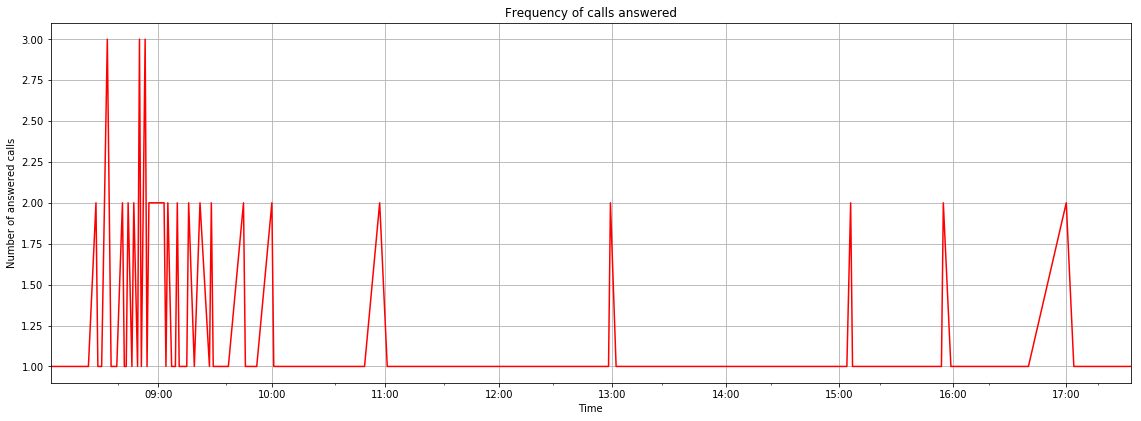

In [12]:
#we have our dfSingle. now remove all counts=0

dfSingle_filt = dfSingle[dfSingle.Count != 0]
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.plot(dfSingle_filt.Time,dfSingle_filt.Count,"r-")
ax.set_xlabel("Time")
ax.set_ylabel("Number of answered calls")
ax.set_title("Frequency of calls answered")


datemin = dfSingle_filt["Time"].min()
datemax = dfSingle_filt["Time"].max()
ax.set_xlim(datemin, datemax)

for label in ax.xaxis.get_ticklabels():
    label.set_rotation(0)
###set major ticks format    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(MaxNLocator(integer=True))

ax.grid(True)
###set ticks every week
#ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter('%d')
#ax.xaxis.set_minor_locator(mdates.MinuteLocator())
###ax.xaxis.set_minor_locator(months)



#plt.show()

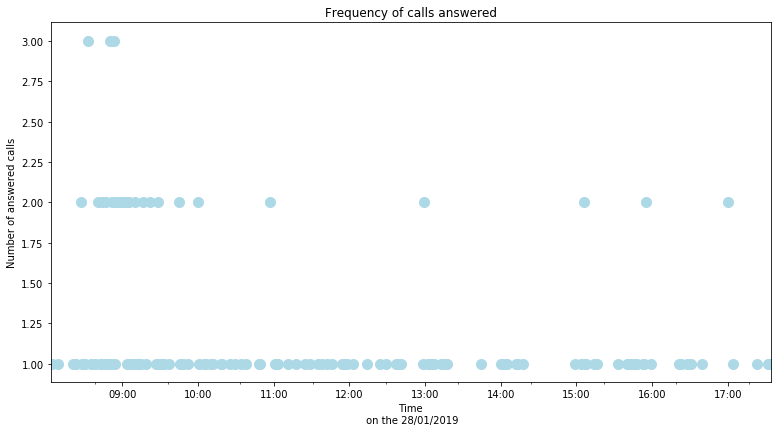

In [13]:

#plt.scatter(dates, PM_25, s =100, c = 'red')
dfSingle_filt = dfSingle[dfSingle.Count != 0]
dfSingle_filt = dfSingle_filt.set_index("Time")

fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])#(xO,yO,w,h)



      
ax.scatter(dfSingle_filt.index.values, dfSingle_filt["Count"],s =100, c = 'lightblue')


ax.set_xlabel(f"Time\n on the {usr_choose_day}")
ax.set_ylabel("Number of answered calls")
ax.set_title("Frequency of calls answered")


datemin = dfSingle_filt.index.values.min()
datemax = dfSingle_filt.index.values.max()
ax.set_xlim(datemin, datemax)
#ax.yaxis.set_ticks([1,2,3])
for label in ax.xaxis.get_ticklabels():
    label.set_rotation(0)
####set major ticks format    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_minor_locator(MaxNLocator(integer=True))

